<a href="https://colab.research.google.com/github/imran9891/TensorFlow/blob/main/10_time_series_forecasing_with_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time series forecasting with TensorFlow + Milestone Project 3: BitPredict

Let's write some TensorFlow code to predict the price of Bitcoin based on the historical price of Bitcoin.

**Note:** This is not a financial advice.

## Get data

We're going to be using the historical price data of Bitcoin to try and predict the future price of Bitcoin, we downloaded the data from here: https://www.coindesk.com/price/bitcoin/

### Importing time series data with pandas

In [2]:
# Import with pandas 
import pandas as pd
# Let's read in our Bitcoin data and parse the dates
df = pd.read_csv("drive/MyDrive/Bitcoin/BTC_data.csv",parse_dates=["Date"],index_col=["Date"])
df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2014-11-03,BTC,331.60083,325.22633,333.75983,319.04350
2014-11-04,BTC,324.71833,331.60083,332.75133,323.06333
2014-11-05,BTC,332.45666,324.71833,335.81166,320.93333
2014-11-06,BTC,336.58500,332.45666,341.49000,328.56166
2014-11-07,BTC,346.77500,336.58500,351.57500,336.02833


In [3]:
df.tail()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2021-09-03,BTC,49725.532134,48834.363592,50344.664659,48619.469617
2021-09-04,BTC,49709.611994,49274.784115,51016.027011,48364.226963
2021-09-05,BTC,49999.555579,50012.441556,50558.733515,49429.569151
2021-09-06,BTC,51693.809398,49945.336568,51827.319488,49515.541880
2021-09-07,BTC,52506.685647,51764.155302,52647.551866,51026.821010


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2500 entries, 2014-11-03 to 2021-09-07
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2500 non-null   object 
 1   Closing Price (USD)  2500 non-null   float64
 2   24h Open (USD)       2500 non-null   float64
 3   24h High (USD)       2500 non-null   float64
 4   24h Low (USD)        2500 non-null   float64
dtypes: float64(4), object(1)
memory usage: 117.2+ KB


In [5]:
# How many samples do we have?
len(df)

2500

We've collected the historical prices of Bitcoin for the past ~7 years but thers's only 2500 samples.

Typically deep learning models usually be like lots and lots of samples (from thousands to tens of thousands to millions).

A smaller number of samples is something you'll often run into with time-series data problems.

**Note:** The **seasonality** of a time series dataset is referred as the number of samples per year. So for our Bitcoin data, it has a seasonality of daily or value of 365 because we collect one sample per day meaning we'll get 365 samples per year.

## Time series patterns

* **Trend:** Time series has a clear long-term increase or decrease (may or may not be linear)

* **Seasonal:** Time series affected by seasonal factors such as time of year (e.g. increased sales towards the end of year) or day of week.

* **Cyclic:** Time series shows rises and falls over an unfixed period, these tend to be longer/more variable than seasonal patterns.

* **Univariate:** Only one variable (e.g. using the price of the Bitcoin to predict the price of Bitcoin).

* **Multivariate:** More than one variable (e.g. using the price of Bitcoin as well as the block reward size to predict the price of Bitcoin).

In [9]:
## Visualize only Date and Closing Price (USD)
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)":"Price"})
bitcoin_prices.head()

,Price
Date,
2014-11-03,331.60083
2014-11-04,324.71833
2014-11-05,332.45666
2014-11-06,336.58500
2014-11-07,346.77500


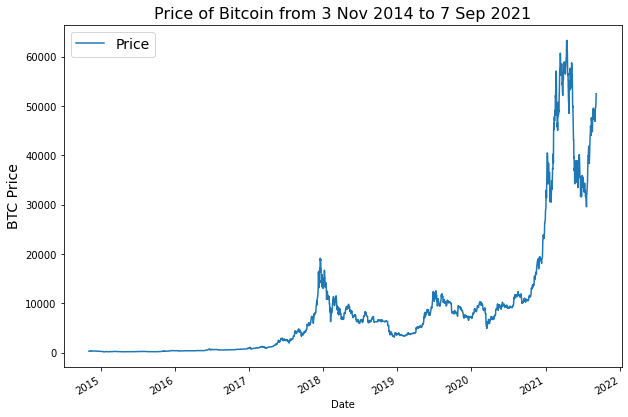

In [14]:
import matplotlib.pyplot as plt
bitcoin_prices.plot(figsize=(10,7))
plt.ylabel("BTC Price",fontsize=14)
plt.title("Price of Bitcoin from 3 Nov 2014 to 7 Sep 2021",fontsize=16)
plt.legend(fontsize=14);


## Importing time series data with Python's CSV module

In [27]:
# Importing and formatting historical Bitcoin data with Python
import csv
import datetime as dt

timesteps = []
btc_price = []
with open("drive/MyDrive/Bitcoin/BTC_data.csv","r") as f:
  csv_reader = csv.reader(f, delimiter=",")
  next(csv_reader) # skip first line (this gets rid of the column titles)
  for line in csv_reader:
    timesteps.append(dt.datetime.strptime(line[1], "%Y-%m-%d")) # get the dates as dates (not strings)
    btc_price.append(float(line[2])) # get the closing price as float

# View first 10 of each
timesteps[:10],btc_price[:10]

([datetime.datetime(2014, 11, 3, 0, 0),
  datetime.datetime(2014, 11, 4, 0, 0),
  datetime.datetime(2014, 11, 5, 0, 0),
  datetime.datetime(2014, 11, 6, 0, 0),
  datetime.datetime(2014, 11, 7, 0, 0),
  datetime.datetime(2014, 11, 8, 0, 0),
  datetime.datetime(2014, 11, 9, 0, 0),
  datetime.datetime(2014, 11, 10, 0, 0),
  datetime.datetime(2014, 11, 11, 0, 0),
  datetime.datetime(2014, 11, 12, 0, 0)],
 [331.60083,
  324.71833,
  332.45666,
  336.585,
  346.775,
  344.81166,
  343.065,
  358.50166,
  368.07666,
  376.99666])

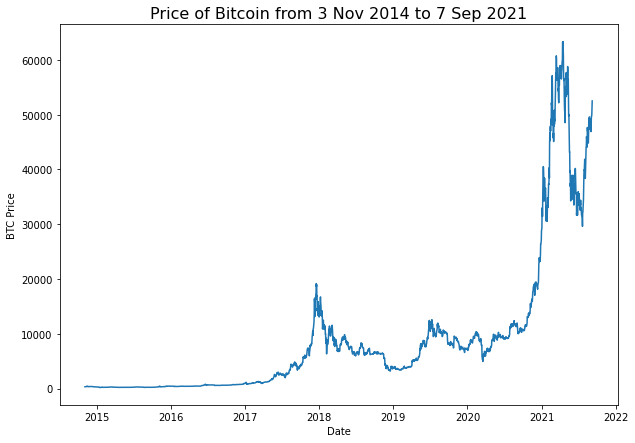

In [16]:
# Plot from CSV
plt.figure(figsize=(10,7))
plt.plot(timesteps, btc_price)
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 3 Nov 2014 to 7 Sep 2021",fontsize=16)
plt.xlabel("Date");

## Format data part 1: Create train and test sets of our time series data

### Creating train and test sets with time series data (the wrong way)

In [29]:
bitcoin_prices[:5]

,Price
Date,
2014-11-03,331.60083
2014-11-04,324.71833
2014-11-05,332.45666
2014-11-06,336.58500
2014-11-07,346.77500


In [33]:
# Get bitcoin date array
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices.Price.to_numpy()

timesteps[:10], prices[:10]

(array(['2014-11-03T00:00:00.000000000', '2014-11-04T00:00:00.000000000',
        '2014-11-05T00:00:00.000000000', '2014-11-06T00:00:00.000000000',
        '2014-11-07T00:00:00.000000000', '2014-11-08T00:00:00.000000000',
        '2014-11-09T00:00:00.000000000', '2014-11-10T00:00:00.000000000',
        '2014-11-11T00:00:00.000000000', '2014-11-12T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([331.60083, 324.71833, 332.45666, 336.585  , 346.775  , 344.81166,
        343.065  , 358.50166, 368.07666, 376.99666]))

In [34]:
# Wrong way to make train/test sets for time series data
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(timesteps,prices,test_size=0.2,random_state=42)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((2000,), (500,), (2000,), (500,))

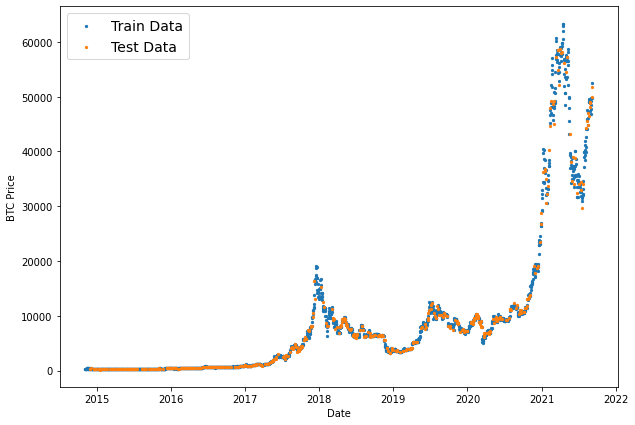

In [35]:
# Let's plot wrong train and test splits
plt.figure(figsize=(10,7))
plt.scatter(X_train,y_train,s=5,label="Train Data")
plt.scatter(X_test,y_test,s=5,label="Test Data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14);

## Create train & test sets for time series (the right way)

In [39]:
# Create train and test splits the right way for time series data
split_size = int(0.8 * len(prices)) # 80% train, 20% test -we can change these values as needed

# Create train data splits (everything before the split)
X_train, y_train = timesteps[:split_size], prices[:split_size]

# Create test data splits (everything after the split)
X_test, y_test = timesteps[split_size:], prices[split_size:]

X_train.shape,X_test.shape,y_train.shape,y_test.shape

((2000,), (500,), (2000,), (500,))

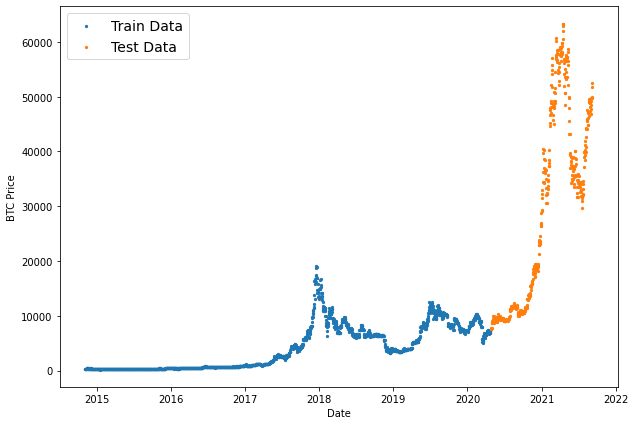

In [40]:
# Let's plot right train and test splits
plt.figure(figsize=(10,7))
plt.scatter(X_train,y_train,s=5,label="Train Data")
plt.scatter(X_test,y_test,s=5,label="Test Data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14);

## Create a plotting function

Typing plotting code is tedious, let's functionize it.

In [41]:
# Create a function to plot time series data
def plot_time_series(timesteps, values, format=".", start=0, end=None, label=None):
  """
  Plots timesteps (a series of points in time) against values (a series of values accross timesteps)

  Parameters
  ----------
  timesteps: array of timestep values
  values: array of values accross time
  format: style of plot, default "."
  start: where to start the plot (setting a value will index from start of timesteps & values)
  end: where to end the plot (similar to staet but for the end)
  label: label to show on plot about values, default None
  """

  # Plot the series
  plt.figure(gigsize=(10,7))
  plt.plot(timesteps[start:end], values[start:end], format=format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label:
    plt.legend(fontsize=14) # make label bigger
  plt.grid(True)


In [ ]:
# Test out plotting function
plot_time_series(timesteps=X_train,
                 values=y_train,
                 label="Train data")